# M1 Project fall 2019: Financial data about vehicle loan default prediction. 


Groupmembers:
1. Claus Mørkbak Højrup,
2. Alexander Prip, 
3. Martin Jæger Nielsen, 
4. Mark von Kelaita

This notebook can be accessed here: https://colab.research.google.com/drive/1gTQ_F7BUl5kzPY4Jg9KfptAUtUjRqS8j

Github link here: https://github.com/mvonke15/SDS-M1---Group-assignment


**Origin of dataset.**

This project is based on data from Kaggle. 

https://www.kaggle.com/mamtadhaker/lt-vehicle-loan-default-prediction

We have chosen data that gives us a chance to work with a problem that relate to the real world. In this case: How can we help financial institutions to prevent loses due to the default of vehicle loans. 

The dataset has Loanee Information (Demographic data like age, Identity proof etc.) Loan Information (Disbursal details, loan to value ratio etc.) Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)

The data comes in three sets: test, train and a feature describtion.






In [0]:
# Import stuff

# Importing modules
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
from sklearn.cluster import KMeans


# Allow access to www.netfordig.dk
import ssl
ssl.match_hostname = lambda cert, hostname: True

dictionary = pd.read_csv('https://www.netfordig.dk/m1project/mod_data/data_dictionary.csv')
test = pd.read_csv('https://www.netfordig.dk/m1project/mod_data/test.csv')
train = pd.read_csv('https://www.netfordig.dk/m1project/mod_data/train.csv')
print("Datasets loaded")

Datasets loaded


In [0]:
# Initial overview of dataframe
test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date_of_Birth,Employment_Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [0]:
# Initial overview of dataframe
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date_of_Birth,Employment_Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES
420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


# PREPROCESING ON TEST AND TRAIN SET - MERGE DATESETS.

We observe that our test and train dataframes are not compatible, thus needs some preprocessing. The 'train' dataframe have columns which are shifted to the left as well as another index than 'test' dataframe.

This means that we aren't able to use them for classification in the state they are now. Likewise, we don't have knowledge about how the original split was undertaken. Was it done manually or using test/train split method which we will use later?

The safe method for us would be to preprocess the two dataframes, merge them and later complete our own and controlled test/train splits.

We will do that with the code below.

In [0]:
# reset index in traindata.  
train.reset_index(inplace=True)

# We have one additional column in the 'train' dataframe now. Thus we drop the last one as this 'info' is not available in the 'test' dataframe.
train.drop(['NO_OF_INQUIRIES'], axis=1, inplace=True)
# Defining new column-names for the 'train' dataframe based on the 'test' dataframe names.
new_cols = test.columns

# Replacing old column names.
train.columns = new_cols

# Merging the dataframes
loans = pd.merge(test, train, how='outer')
loans.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date_of_Birth,Employment_Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


# PREPROCESSING ON MERGED DATASET

After merging test and train, we would like to convert all the objectbased columns to numerical values, so we can scale the data.
Using head() and info() we observe, that we will have to work on the following columns:

1. CREDIT_HISTORY_LENGTH: Column is filled with objects (strings), that need to be number.
2. AVERAGE_ACCT_AGE: Column is filled with objects (strings), that need to be number.
3. Date_of_Birth: Column is filled with objects (strings), that need to be datetime.
4. DisbursalData: Column is filled with objects (strings), that need to be datetime.
5. Employment_Type: Column is filled with objects (strings), that need to be number. 
6. PERFORM_CNS_SCORE_DESCRIPTION: This a description of another columns data. We dont need that.
7. We need DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS turned into something more manageable eg. when is a loan default or not.


In [0]:
# The number of months without payment, before we consider a loan default eg 1 means that 0 and 1 months late is "OK".
# 2 month or above and we consider (for the purpose this project) that the loan is default. 
# The n_default variable can be changed. 
n_default = 1

In [0]:
# Define function for replacing X yrs and X mon in CREDIT_HISTORY_LENGTH and AVERAGE_ACCT_AGE:
def converter(text):
  # Splits at space 
  substrings = text.split()
  sub1 = substrings[0].replace('yrs', '')
  sub2 = substrings[1].replace('mon', '')
  sub1 = int(sub1)
  sub2 = int(sub2)
  mon1 = sub1 *12
  mon=mon1 + sub2
  return mon

# Applying converter function
loans['CREDIT_HISTORY_LENGTH'] = loans.CREDIT_HISTORY_LENGTH.apply(converter)
loans['AVERAGE_ACCT_AGE'] = loans.AVERAGE_ACCT_AGE.apply(converter)

In [0]:
# Converting objects to datetime - SLOW.
loans['Date_of_Birth'] = pd.to_datetime(loans['Date_of_Birth'], errors='coerce')
loans['DisbursalDate'] = pd.to_datetime(loans['DisbursalDate'], errors='coerce')

# today = this is the day, to which we estimate age. It's the last date in the Disbursal columns => last recorded day of the dataframe.
today = loans['DisbursalDate'].max()

In [0]:
loans['AGE_IN_DAYS'] = ((today - loans['Date_of_Birth'])) # input in days, not in years. This doesn´t matters, because we scale later.
loans['AGE_IN_DAYS'] = loans['AGE_IN_DAYS'].dt.days

In [0]:
# Label encode objects specifying type of work/employment.
loans['Employment_Type'] = loans.Employment_Type.fillna('Unknown')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
loans['Employment_Type'] = le.fit_transform(loans['Employment_Type'])


In [0]:
# We drop columns that are no longer needed.
loans.drop(['PERFORM_CNS_SCORE_DESCRIPTION'], axis=1, inplace=True) # Not relevant for classification. Just at description of another column´s data.
loans.drop(['Date_of_Birth'], axis=1, inplace=True) # Not relevant for classification. We changes this into age in days.

In [0]:
loans["Default"] = np.nan

# Function for making booleans for default or not. Anything above 1 months delayed payment is deafult in this case.
def defaultconverter(number):
  if number > n_default:
    value = 1
  else:
    value = 0
  return value

# Applying converter function
loans['Default'] = loans.DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS.apply(defaultconverter)



In [0]:
# Our new dateframe - top 5
loans.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment_Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,AGE_IN_DAYS,Default
0,655269,53478,63558,86.54,67,22807,45,1497,0,2018-03-11,6,1998,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16415,0
1,723482,55513,63163,89.45,67,22807,45,1497,1,2018-11-20,6,1998,1,1,0,0,0,0,749,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,8,12,1,12258,0
2,758529,65282,84320,79.93,78,23135,86,2071,0,2018-11-29,4,1646,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8459,0
3,763449,46905,63896,76.58,78,17014,45,2070,1,2018-11-29,4,1646,1,1,0,0,0,0,14,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,29,29,0,16775,0
4,708663,51428,63896,86.08,78,17014,45,2069,0,2018-11-17,4,1646,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17141,0


In [0]:
# Our new dataframe - bottom 5.
loans.tail()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment_Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,AGE_IN_DAYS,Default
345541,626432,63213,105405,60.72,34,20700,48,1050,0,2018-10-26,6,3705,1,0,0,1,0,0,735,4,3,0,390443,416133,416133,0,0,0,0,0,0,4084,0,0,0,21,39,0,11295,0
345542,606141,73651,100600,74.95,34,23775,51,990,1,2018-10-23,6,3705,1,0,0,1,0,0,825,1,0,0,0,0,0,0,0,0,0,0,0,1565,0,0,0,6,6,0,11170,0
345543,613658,33484,71212,48.45,77,22186,86,2299,0,2018-10-24,4,3479,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15680,0
345544,548084,34259,73286,49.10,77,22186,86,2299,0,2018-09-29,4,3479,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9026,0
345545,630213,75751,116009,66.81,77,22186,86,2299,0,2018-10-27,4,3479,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12715,0


In [0]:
# Ensuring that we have the required format.
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345546 entries, 0 to 345545
Data columns (total 40 columns):
UniqueID                               345546 non-null int64
disbursed_amount                       345546 non-null int64
asset_cost                             345546 non-null int64
ltv                                    345546 non-null float64
branch_id                              345546 non-null int64
supplier_id                            345546 non-null int64
manufacturer_id                        345546 non-null int64
Current_pincode_ID                     345546 non-null int64
Employment_Type                        345546 non-null int64
DisbursalDate                          345546 non-null datetime64[ns]
State_ID                               345546 non-null int64
Employee_code_ID                       345546 non-null int64
MobileNo_Avl_Flag                      345546 non-null int64
Aadhar_flag                            345546 non-null int64
PAN_flag                

In [0]:
# Checking for missing values.
loans.isnull().sum()

UniqueID                               0
disbursed_amount                       0
asset_cost                             0
ltv                                    0
branch_id                              0
supplier_id                            0
manufacturer_id                        0
Current_pincode_ID                     0
Employment_Type                        0
DisbursalDate                          0
State_ID                               0
Employee_code_ID                       0
MobileNo_Avl_Flag                      0
Aadhar_flag                            0
PAN_flag                               0
VoterID_flag                           0
Driving_flag                           0
Passport_flag                          0
PERFORM_CNS_SCORE                      0
PRI_NO_OF_ACCTS                        0
PRI_ACTIVE_ACCTS                       0
PRI_OVERDUE_ACCTS                      0
PRI_CURRENT_BALANCE                    0
PRI_SANCTIONED_AMOUNT                  0
PRI_DISBURSED_AM

In [0]:
# Ensuring that we have borrowers that pays in time and as well as delinquent ones.
loans.Default.unique()

array([0, 1])

**Conclusion of preproccesing.**

We have removed selected features/columns and converted objecs to number. We can now do some descriptive statistics in the dataset and later scale it. We can also observe whether we have outliers or not.


# GENERAL DESCRIPTION OF THE DATAFRAME.



Below we do some initial exploration of the dataframe. We find that the total amount of issued loans are 345.546 from which 4.718 to varying extend are delinquent. In total there have been issued loans worth 18.976.134.542 USD. This has occured in 82 branches split across 22 states with 3.398 employees in total. In regard to the borrower the mean age is 26,19 and the mean loan issued is 54.916 USD for a mean cost of a car at 76.294 USD.

In [0]:
# Codes for description of dataframe
n_loans = loans.UniqueID.nunique()
n_default = loans.Default.sum() 
p_default = n_default/n_loans
n_branches = loans.branch_id.nunique()
n_employees = loans.Employee_code_ID.nunique()
n_states = loans.State_ID.nunique()
m_age = (loans.AGE_IN_DAYS.mean()/365)
m_carcost = loans.asset_cost.mean()
max_date = pd.to_datetime(loans['DisbursalDate'].max()).date()
min_date = pd.to_datetime(loans['DisbursalDate'].min()).date()
n_total_loans = loans['disbursed_amount'].sum()
n_mean_loans = loans['disbursed_amount'].mean()
n_mean_loan_branch = loans['UniqueID'].nunique()/loans['branch_id'].nunique()

# We print the above 
print("Date ranges from", "\t",  "\t" , min_date, "to ", max_date)
print("Number of loans", "\t","\t", n_loans)
print("Number of defaults", "\t","\t", n_default)
print("Percentages of default loans" , "\t", p_default)
print("Number of none-defaults", "\t",n_loans - n_default)
print("Total amount of Loans", "\t", "\t", n_total_loans)
print("Number of branches", "\t","\t", n_branches)
print("Mean loan by branches", "\t","\t", n_mean_loan_branch)
print("Number of employees", "\t", "\t", n_employees)
print("Number of states", "\t", "\t", n_states)
print("Mean Age", "\t", "\t", "\t", m_age)
print("Mean cost of car",  "\t", "\t", m_carcost)
print("Mean of disbursed","\t", "\t", n_mean_loans)




Date ranges from 	 	 2018-01-08 to  2018-12-11
Number of loans 	 	 345546
Number of defaults 	 	 4718
Percentages of default loans 	 0.013653753769396839
Number of none-defaults 	 340828
Total amount of Loans 	 	 18976134542
Number of branches 	 	 82
Mean loan by branches 	 	 4213.975609756098
Number of employees 	 	 3398
Number of states 	 	 22
Mean Age 	 	 	 26.1905007037106
Mean cost of car 	 	 76294.83864955751
Mean of disbursed 	 	 54916.377391143295


# HOW MANY LOANS ARE ISSUED AND HOW BIG OF A SHARE OF THE LOANS ARE DELIQUINT AFTER 2 MONTHS OR ABOVE?

Months 	 	 Loans 	 Defaults 	 Percentages defaults
2018-01-31 	 1708 	 19 	 	 1.1124121779859486
2018-02-28 	 25 	 0 	 	 0.0
2018-03-31 	 7601 	 128 	 	 1.6839889488225235
2018-04-30 	 4627 	 81 	 	 1.7505943375837476
2018-05-31 	 4178 	 50 	 	 1.1967448539971277
2018-06-30 	 7024 	 91 	 	 1.2955580865603644
2018-07-31 	 4339 	 69 	 	 1.5902281631712378
2018-08-31 	 58586 	 833 	 	 1.4218413955552522
2018-09-30 	 57939 	 799 	 	 1.37903657294741
2018-10-31 	 89440 	 1190 	 	 1.3305008944543828
2018-11-30 	 99420 	 1312 	 	 1.31965399316033
2018-12-31 	 10659 	 146 	 	 1.369734496669481


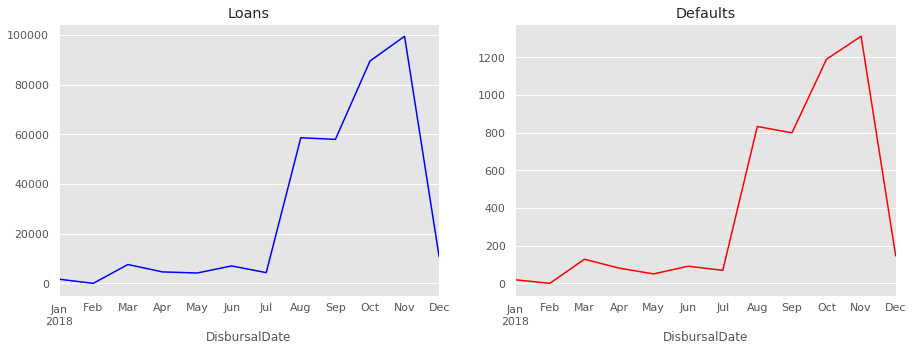

In [0]:
# Sets the size of the visual plot (widt x height).
plt.rcParams["figure.figsize"] =(10,10)

# Copy of loans dataframe for visualizing and reindexing.
resampled_loans = loans.copy()
resampled_loans.set_index(resampled_loans['DisbursalDate'], inplace=True)

# Resample loans
loans_month = resampled_loans.resample('M').UniqueID.count()
loans_month_def = resampled_loans.resample('M').Default.sum()


# Printing text.
print("Months", "\t", "\t", "Loans", "\t",  "Defaults", "\t", "Percentages defaults")
for i in range(len(loans_month)):
    print(pd.to_datetime(loans_month.index[i]).date(), "\t", loans_month[i], "\t", loans_month_def[i], "\t", "\t", (loans_month_def[i]/loans_month[i])*100 )

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
loans_month.plot(ax=ax[0],c ='blue', title='Loans')
loans_month_def.plot(ax=ax[1], c='red', title='Defaults')


# DESCRIPTION OF BORROWERS

In [0]:
# Estimating max. and min. age of the borrower.
max_age = (loans['AGE_IN_DAYS'].max()/365)
min_age = (loans['AGE_IN_DAYS'].min()/365)

print ("Oldest customer:",max_age)
print ("Youngest customer:",min_age)

Oldest customer: 49.97534246575343
Youngest customer: -50.09041095890411


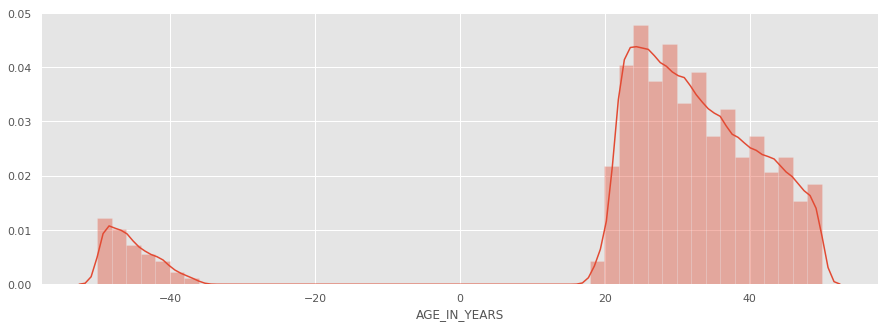

<Figure size 1080x360 with 0 Axes>

In [0]:
# Plotting graph of age distribution of borrowers.
plt.rcParams["figure.figsize"] =(15,5)
loans['AGE_IN_YEARS'] = ((loans['AGE_IN_DAYS'])/365)
#Displot på antal år på folk som låner.
sns.distplot((loans['AGE_IN_YEARS']))
plt.show()

# Clear the distplot
plt.clf()

The graph above is odd as we have borrowers with a negative age. We drop these so we are left with a min. age of 18 as we consider this a 'legal' age to be issued a loan.

In [0]:
# Dropping borrowers below the age of 18.
loans = loans.drop(loans[loans.AGE_IN_DAYS < (18*365)].index)

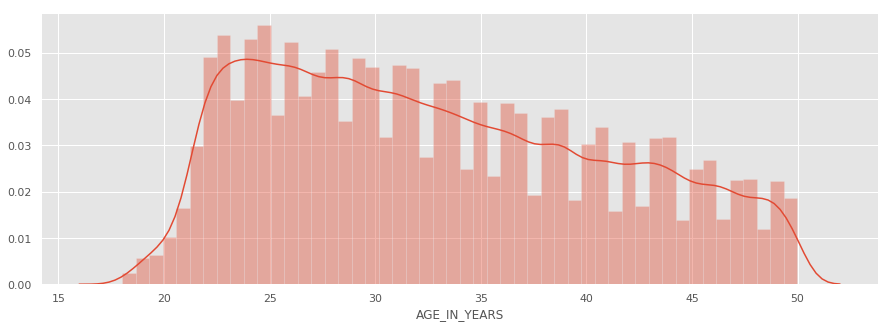

<Figure size 1080x360 with 0 Axes>

In [0]:
# New plot.
plt.rcParams["figure.figsize"] =(15,5)
loans['AGE_IN_YEARS'] = ((loans['AGE_IN_DAYS'])/365)
#Displot på antal år på folk som låner.
sns.distplot((loans['AGE_IN_YEARS']))
plt.show()

# Clear the distplot
plt.clf()

# DESCRIPTION OF THE ASSETS, COMMONALITIES AND MISC.

We want to do some further exploration. Which cars are most predominat in each state, which states has the biggest share of delinquent borrowers, how is the asset distribution (the cost of the car), and what is the disbursed amount.

In [0]:
# Exploring the most predominant car brand by state.
pd.crosstab(loans.State_ID, loans.manufacturer_id)

manufacturer_id,45,48,49,51,67,86,120,145,152,153,155,156
State_ID,,,,,,,,,,,,
1,4060,64,228,3724,19,4496,544,4,0,0,0,0
2,3106,219,57,669,48,2604,78,4,0,0,0,0
3,11666,3989,5237,8050,268,14548,1378,111,0,3,0,0
4,14530,2755,1450,5255,428,35955,3188,356,0,4,0,1
5,2965,976,1249,1717,186,5100,405,46,0,0,0,0
6,14630,2094,523,2112,265,22193,2436,2,0,0,0,0
7,2312,290,1270,2052,367,3374,127,43,0,0,0,0
8,2278,3676,904,2512,26,8073,536,16,0,0,0,0
9,1345,637,323,2104,163,13468,1773,7,8,0,0,0


In [0]:
# Delinquent number of months by state
pd.crosstab(loans.State_ID, loans.DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS)

DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,0,1,2,3,4,5,6,7,8,9,10,11,12,16,18,20
State_ID,,,,,,,,,,,,,,,,
1,11582,1236,239,63,10,5,2,0,1,0,0,0,1,0,0,0
2,6267,424,73,15,6,0,0,0,0,0,0,0,0,0,0,0
3,43457,1562,182,35,11,3,0,0,0,0,0,0,0,0,0,0
4,58633,4368,697,144,47,17,3,5,2,3,1,0,0,1,1,0
5,11812,710,96,14,10,1,0,0,0,0,0,0,1,0,0,0
6,40905,2801,420,88,17,8,6,4,1,2,1,0,1,0,0,1
7,9196,550,69,17,1,1,1,0,0,0,0,0,0,0,0,0
8,16020,1529,339,83,29,12,3,2,3,0,0,1,0,0,0,0
9,17698,1691,339,64,25,5,3,2,1,0,0,0,0,0,0,0


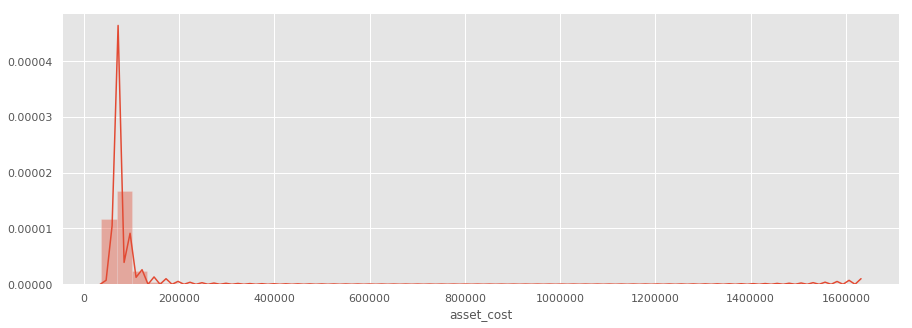

<Figure size 1080x360 with 0 Axes>

In [0]:
# Asset distribution in USD. 

plt.rcParams["figure.figsize"] =(15,5)
# Plot of distribution.
sns.distplot(loans['asset_cost'])
plt.show()
# Clear the distplot.
plt.clf()

An odd plot - not a very normal distribution above. Let´s take a look at what is causing it.


In [0]:
# Estimating max., min., mean, and median of assets.
max_ass = loans['asset_cost'].max()
min_ass = loans['asset_cost'].min()
mean_ass = loans['asset_cost'].mean()
median_ass = loans['asset_cost'].median()
#print ("Most expensive car:",max_ass)
print ("Cheapest car:",min_ass)
print ("Mean car:",mean_ass)
print ("Median car:",median_ass)
print ("Top 10 most expensive cars")
mycars = loans.nlargest(10, ['asset_cost']) 
print(mycars.asset_cost)

Cheapest car: 37000
Mean car: 76497.70291697404
Median car: 71647.0
Top 10 most expensive cars
322644    1628992
199067    1328954
91092     1271553
91094      720592
322647     715186
304998     459625
322645     388025
322646     383600
322642     378092
322643     378092
Name: asset_cost, dtype: int64


In [0]:
# We found some ridiculously priced cars - now we drop assets priced > 180.000 USD.
loans = loans.drop(loans[loans.asset_cost > 180000].index)

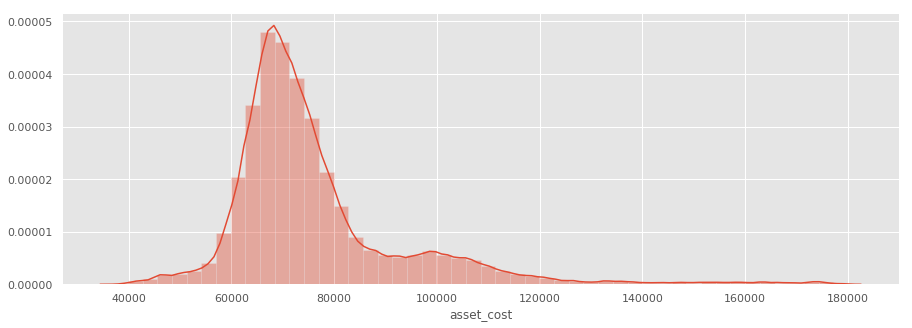

<Figure size 1080x360 with 0 Axes>

In [0]:
plt.rcParams["figure.figsize"] =(15,5)
# New plot of asset distribution.
sns.distplot(loans['asset_cost'])
plt.show()
# Clear the distplot.
plt.clf()

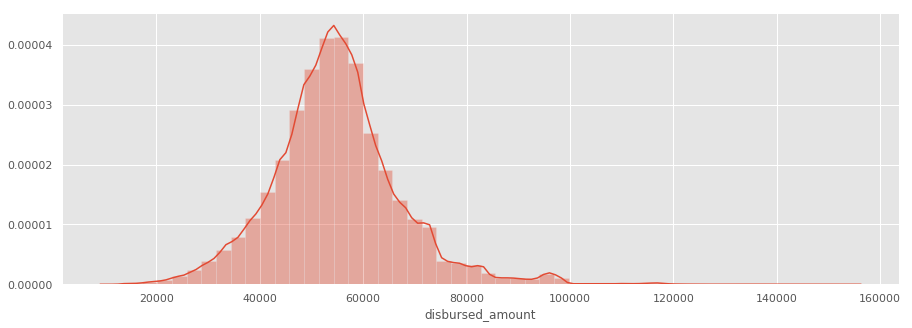

<Figure size 1080x360 with 0 Axes>

In [0]:
# Graphing distribution of disbursed amount (the distribution of loans issued).
plt.rcParams["figure.figsize"] =(15,5)
sns.distplot(loans['disbursed_amount'])
plt.show()
# Clear the distplot.
plt.clf()

In [0]:
# We repeated the proces that we did for assets.
max_ass = loans['disbursed_amount'].max()
min_ass = loans['disbursed_amount'].min()
mean_ass = loans['disbursed_amount'].mean()
median_ass = loans['disbursed_amount'].median()
#print ("Most expensive car:",max_ass)
print ("Smallest loan:",min_ass)
print ("Mean loan:",mean_ass)
print ("Median loan:",median_ass)
print ("Top 10 loans")
toploans = loans.nlargest(10, ['disbursed_amount']) 
print(toploans.asset_cost)

Smallest loan: 11613
Mean loan: 54836.65213804308
Median loan: 54303.0
Top 10 loans
260520    179158
304608    176523
15657     177791
61386     173018
332239    168409
258172    173918
150393    172309
313996    178714
229384    169726
304629    176523
Name: asset_cost, dtype: int64


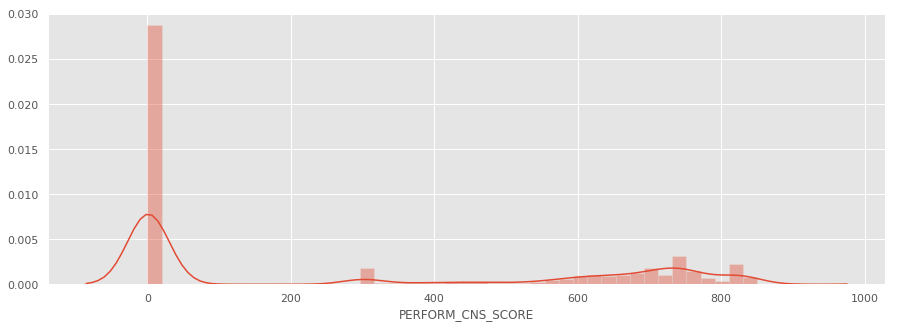

<Figure size 1080x360 with 0 Axes>

In [0]:
# Disribution CNS Score. Max score is 900 in the real world. Do we have any outliers?                      
plt.rcParams["figure.figsize"] =(15,5)
#Displot på lånet størrelse.
sns.distplot(loans['PERFORM_CNS_SCORE'])
plt.show()
# Clear the distplot
plt.clf()

# SCALING THE DATASET

Scaling means that we have to make a standardization of our loans dataset.

This is commonly required for many machine learning estimators implemented in scikit-learn.

If our individual features such as eg. geographical state, customers age and employment type does not look like standard normally distributed data we will get in trouble.

Our loans data are different in scale.

Just looking a loans.head() and loans.tail() show us that the feature 'Asset Cost' goes from 63558 to twice that amount (and this is a quick glance, the actual values could be lower and higher in each end of the scale).

States on the other hand, can naturally only go from 1 to 50 states. And there´s not even that many in the dataset, which means that we dont have data from all 50 US states.

So the two columns are very different in scale. We will need them in a common scale before we continue.

We can do this by scaling the data to mean of 0 and standard deviation of 1.

We will use the StandardScaler for this in the code below. But first we will print out at short describtive analysis of the dataset before scaling, so we have something to compare to the scaled date.

In [0]:
# Dropping columns not relevant for classification.
loans.drop(['DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'], axis=1, inplace=True) # not relevant for classification
loans.drop(['DisbursalDate'], axis=1, inplace=True) # not relevant for classification
loans.drop(['AGE_IN_YEARS'], axis=1, inplace=True) # not relevant for classification

# Describtive analysis of dataset before scaling
pd.DataFrame(loans, columns = loans.columns).describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment_Type,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,AGE_IN_DAYS,Default
count,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.0,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,3.151480e+05,3.151480e+05,3.151480e+05,315148.000000,315148.000000,315148.000000,3.151480e+05,3.151480e+05,3.151480e+05,3.151480e+05,3.151480e+05,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000,315148.000000
mean,592916.290454,54836.652138,76216.488729,74.870799,74.876020,19711.905638,68.613502,3283.596187,0.605763,7.230949,1619.072268,1.0,0.849544,0.113394,0.137329,0.021292,0.002129,283.674052,2.285237,0.978712,0.145018,1.500518e+05,1.924067e+05,1.922020e+05,0.046413,0.022361,0.005721,4.449284e+03,5.801137e+03,5.707227e+03,1.124265e+04,2.567514e+02,0.364238,8.264945,14.696339,0.218224,12016.182308,0.012924
std,101502.815635,12319.584248,17451.604132,11.274966,70.535076,3510.500149,22.128970,2239.759274,0.554659,4.555334,1023.572476,0.0,0.357519,0.317075,0.344195,0.144355,0.046094,338.457608,4.921905,1.841424,0.515971,9.014039e+05,1.093631e+06,1.100562e+06,0.563192,0.284374,0.098323,1.633223e+05,1.621416e+05,1.616244e+05,2.015067e+05,1.636089e+04,0.929757,14.218893,26.068637,0.728684,2939.879980,0.112947
min,417429.000000,11613.000000,37000.000000,10.030000,1.000000,10524.000000,45.000000,1.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,6574.000000,0.000000
25%,505218.750000,47649.000000,66308.750000,69.240000,14.000000,16594.000000,45.000000,1460.000000,0.000000,4.000000,734.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,9475.000000,0.000000
50%,592586.000000,54303.000000,71616.000000,77.030000,64.000000,20470.000000,86.000000,2795.000000,1.000000,6.000000,1509.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,11661.000000,0.000000
75%,680309.250000,60947.000000,79814.000000,83.580000,135.000000,23062.000000,86.000000,5491.000000,1.000000,10.000000,2462.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,675.000000,2.000000,1.000000,0.000000,2.722800e+04,5.364550e+04,5.200000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.782000e+03,0.000000e+00,0.000000,12.000000,22.000000,0.000000,14224.000000,0.000000
max,769909.000000,153803.000000,180000.000000,95.000000,261.000000,24901.000000,153.000000,7345.000000,2.000000,22.000000,3923.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,890.000000,453.000000,65.000000,22.000000,9.652492e+07,1.058657e+08,1.057557e+08,57.000000,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,8.526233e+07,5.390000e+06,35.000000,369.000000,369.000000,36.000000,18241.000000,1.000000


In [0]:
# Installing Scaler.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Picking the columns, that we would like to work with.
loans_features = loans.loc[:,'disbursed_amount':'AGE_IN_DAYS']

# Scaling the data.
scaler = StandardScaler().fit(loans_features)
loans_scaled = scaler.transform(loans_features)

# Showing scaled data
pd.DataFrame(loans_scaled, columns=loans_features.columns).describe().round(3)

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment_Type,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,AGE_IN_DAYS
count,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.0,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000,315148.000
mean,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.0,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-3.509,-2.247,-5.751,-1.047,-2.617,-1.067,-1.466,-1.092,-1.368,-1.581,0.0,-2.376,-0.358,-0.399,-0.147,-0.046,-0.838,-0.464,-0.531,-0.281,-7.575,-0.176,-0.175,-0.082,-0.079,-0.058,-3.546,-0.036,-0.035,-0.056,-0.016,-0.392,-0.581,-0.564,-0.299,-1.851
25%,-0.583,-0.568,-0.499,-0.863,-0.888,-1.067,-0.814,-1.092,-0.709,-0.865,0.0,0.421,-0.358,-0.399,-0.147,-0.046,-0.838,-0.464,-0.531,-0.281,-0.166,-0.176,-0.175,-0.082,-0.079,-0.058,-0.027,-0.036,-0.035,-0.056,-0.016,-0.392,-0.581,-0.564,-0.299,-0.864
50%,-0.043,-0.264,0.192,-0.154,0.216,0.786,-0.218,0.711,-0.270,-0.108,0.0,0.421,-0.358,-0.399,-0.147,-0.046,-0.838,-0.464,-0.531,-0.281,-0.166,-0.176,-0.175,-0.082,-0.079,-0.058,-0.027,-0.036,-0.035,-0.056,-0.016,-0.392,-0.581,-0.564,-0.299,-0.121
75%,0.496,0.206,0.772,0.852,0.954,0.786,0.986,0.711,0.608,0.824,0.0,0.421,-0.358,-0.399,-0.147,-0.046,1.156,-0.058,0.012,-0.281,-0.136,-0.127,-0.127,-0.082,-0.079,-0.058,-0.027,-0.036,-0.035,-0.047,-0.016,-0.392,0.263,0.280,-0.299,0.751
max,8.033,5.947,1.785,2.639,1.478,3.813,1.813,2.514,3.242,2.251,0.0,0.421,2.796,2.506,6.780,21.649,1.791,91.573,34.767,42.357,106.917,96.626,95.918,101.127,126.516,81.306,220.597,184.988,185.581,423.069,329.429,37.253,25.370,13.591,49.105,2.117


In [0]:
# New info
loans.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 315148 entries, 0 to 345545
Data columns (total 38 columns):
UniqueID                        315148 non-null int64
disbursed_amount                315148 non-null int64
asset_cost                      315148 non-null int64
ltv                             315148 non-null float64
branch_id                       315148 non-null int64
supplier_id                     315148 non-null int64
manufacturer_id                 315148 non-null int64
Current_pincode_ID              315148 non-null int64
Employment_Type                 315148 non-null int64
State_ID                        315148 non-null int64
Employee_code_ID                315148 non-null int64
MobileNo_Avl_Flag               315148 non-null int64
Aadhar_flag                     315148 non-null int64
PAN_flag                        315148 non-null int64
VoterID_flag                    315148 non-null int64
Driving_flag                    315148 non-null int64
Passport_flag          

# USML - A closer look at the patterns of the dataset.


After preproccesing, we have 36 features. While preprocessing we removed some features. There was some descriptions that we didn´t need, and we also added an 'AGE' column and removed an 'Data_of_birth" column. This is called feature selection (or in this case it´s more accurate to call it feature reduction).

36 features are still a lot to work with. We could expand on our features selection and remove more features. Do we really need to know which customer provided copy of drivers license, voters registration, passport etc. Would it not be enough to just register if the customer provided valid ID or not? Perhaps, but such a destinction would be subjective on our part, and we would not know the value of the information that we drop.

The alternative is dimensionality reduction. Both feature selection and dimensionality reduction can be used to reduce features, but while feature selection is simply selecting and excluding given features without changing them, dimensionality reduction transforms features into a lower dimension

We will show examples of how this proces work later, but for now we will start by looking at one method to reduce dimensions. This is called Principal Component Analysis (PCA)


# Principal Component Analysis (PCA)

We start with a quick exploratory analysis and try to fit our 36 features into a PCA-model and explore what datavalue each feature has.


In [0]:
# Import the module and instantiate a PCA object
from sklearn.decomposition import PCA
pca = PCA(n_components=36) # We test with 36 component. 100% of our features.

loans_pca = pca.fit_transform(loans_scaled)
pca.components_.shape # This will show us the number of new dimensions compared to the previous number. Should be 36,36 in this case.

(36, 36)

**Measuring the effect of the dimensionality reduction.**

We can measure the effect of the dimensionality reduction with the variance ratio. That will tell us, how much information each of the 36 components holds. See the code below. The cumulative ratio should be 100% since we add up all 36 dimension.



In [0]:
# PCA Explained variance ratio

# Ratio for each of the 36 components.
evr = pca.explained_variance_ratio_

print("Amount of information in each component\n")
print("This will show us that the first component give us 13% of the information in the dataset\n")
print("Second component gives us an additionel 10% of information. And so on.\n")
for x in evr:
  print(x)
  
  
print("\n\nThe culumative information in all 36 components\n")
sum(pca.explained_variance_ratio_)*100

Amount of information in each component

This will show us that the first component give us 13% of the information in the dataset

Second component gives us an additionel 10% of information. And so on.

0.1346404888064898
0.10148927662573498
0.06803604806262596
0.05987971459915027
0.051233307517296545
0.04412768006965651
0.043245310043107166
0.040818351620501764
0.040157718865954185
0.030146299303479136
0.02924471882024796
0.028708255271356776
0.02817879420976068
0.027739468746107214
0.027467714497850758
0.026535283283440955
0.025680088570444435
0.024789374234658972
0.023920665009717824
0.02363738802305909
0.022173064923007416
0.020589642637735203
0.017494695009043795
0.015791741840524894
0.012644927832113162
0.01071680803961414
0.004927534385552019
0.004567992218540314
0.004220824316754977
0.003223330059561496
0.0018698436190545098
0.001602087651433787
0.0003634103940781528
0.0001290190125250084
9.131879820368208e-06
6.0629737117839655e-34


The culumative information in all 36 compon

100.00000000000003

**Visualizing the components and their values**. 

It can be hard to read the numbers. A 2D graph will make that easier.

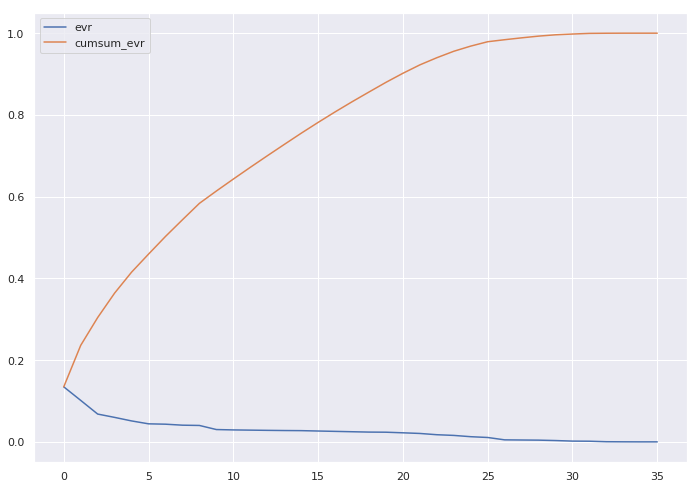

In [0]:
# Plotting graph
plot_data = pd.DataFrame({'evr': pca.explained_variance_ratio_, 'cumsum_evr': np.cumsum(pca.explained_variance_ratio_)}).stack()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(y = plot_data.values, x = plot_data.index.get_level_values(0), hue=plot_data.index.get_level_values(1))

**The result.**

The graph above (red line) show that we dont need all 36 components in order to retain 100% of our information. In fact, we could reduce the dimensions to 30 and still retain 100% af value in the dataset.

On the other hand, if we reduce to 1 component, we will only have 13% of our data´s value.

**What would be an acceptable amount of dataloss?**
As a rule of thumb 90% of the data´s value should be retained. Looking at the graph, we see that 20 component will get us a little less than 90%. We choose 23 components and continue.



In [0]:
# Running PCA again, now with 23 component.
pca = PCA(n_components=23) 

loans_pca = pca.fit_transform(loans_scaled)
pca.components_.shape # This will show us the number of new dimensions compared to the previous number. Should be 23,36 in this case.

(23, 36)

In [0]:
# PCA Explained variance ratio
evr = pca.explained_variance_ratio_

print("\n\nThe culumative information in 23 principal components\n")
sum(pca.explained_variance_ratio_)*100



The culumative information in 23 principal components



93.9933348750427

After applying the PCA and compressing the data into the 23 component, we get a new dataframe.

But which of the original 36 features affects the 23 principal component the most? Run the code below and you will get a visual answer to that question.

<IPython.core.display.Javascript object>

[Text(0, 0.5, 'disbursed_amount'),
 Text(0, 1.5, 'asset_cost'),
 Text(0, 2.5, 'ltv'),
 Text(0, 3.5, 'branch_id'),
 Text(0, 4.5, 'supplier_id'),
 Text(0, 5.5, 'manufacturer_id'),
 Text(0, 6.5, 'Current_pincode_ID'),
 Text(0, 7.5, 'Employment_Type'),
 Text(0, 8.5, 'State_ID'),
 Text(0, 9.5, 'Employee_code_ID'),
 Text(0, 10.5, 'MobileNo_Avl_Flag'),
 Text(0, 11.5, 'Aadhar_flag'),
 Text(0, 12.5, 'PAN_flag'),
 Text(0, 13.5, 'VoterID_flag'),
 Text(0, 14.5, 'Driving_flag'),
 Text(0, 15.5, 'Passport_flag'),
 Text(0, 16.5, 'PERFORM_CNS_SCORE'),
 Text(0, 17.5, 'PRI_NO_OF_ACCTS'),
 Text(0, 18.5, 'PRI_ACTIVE_ACCTS'),
 Text(0, 19.5, 'PRI_OVERDUE_ACCTS'),
 Text(0, 20.5, 'PRI_CURRENT_BALANCE'),
 Text(0, 21.5, 'PRI_SANCTIONED_AMOUNT'),
 Text(0, 22.5, 'PRI_DISBURSED_AMOUNT'),
 Text(0, 23.5, 'SEC_NO_OF_ACCTS'),
 Text(0, 24.5, 'SEC_ACTIVE_ACCTS'),
 Text(0, 25.5, 'SEC_OVERDUE_ACCTS'),
 Text(0, 26.5, 'SEC_CURRENT_BALANCE'),
 Text(0, 27.5, 'SEC_SANCTIONED_AMOUNT'),
 Text(0, 28.5, 'SEC_DISBURSED_AMOUNT'),
 Te

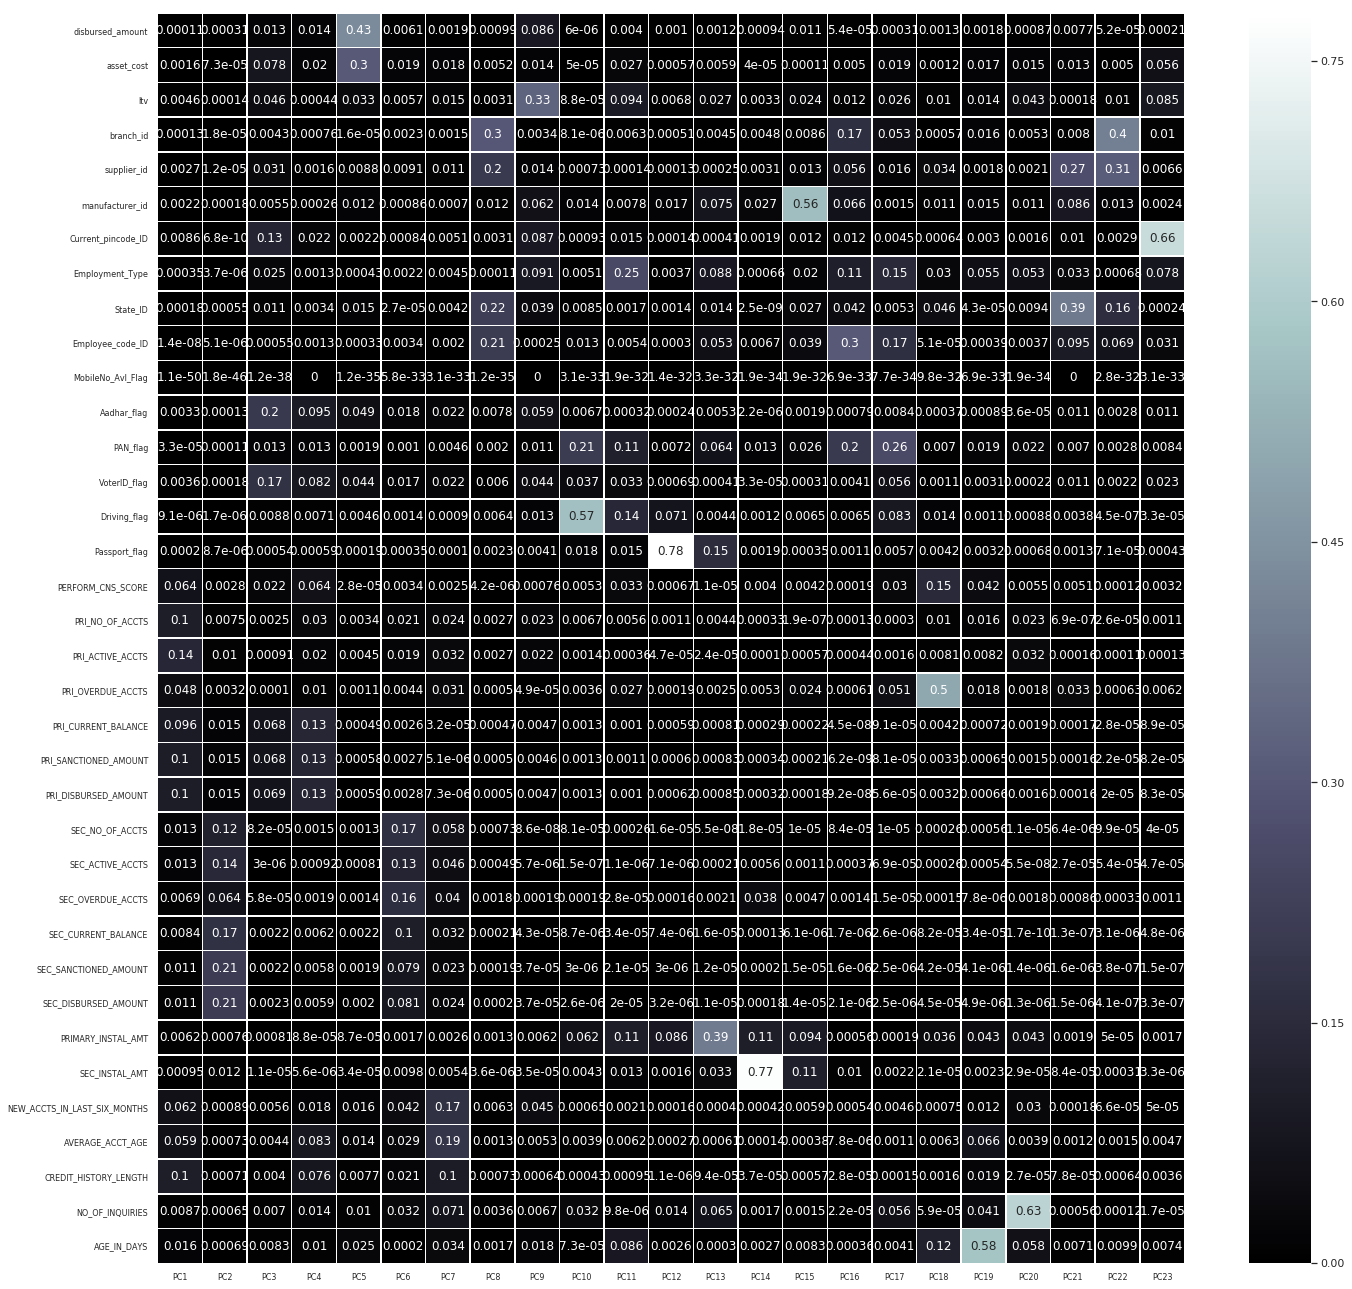

In [0]:
#Visualizing loading of the PCA

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

cols = ['disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
       'Employment_Type', 'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS',
       'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE',
       'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS',
       'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
       'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT',
       'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE',
       'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES', 'AGE_IN_DAYS']

loans_principal_components = pca.fit_transform(loans_scaled)
loans_principal_data = pd.DataFrame(data = loans_principal_components, columns = ['PC1', 'PC2','PC3','PC4','PC5', 'PC6','PC7','PC8','PC9', 'PC10','PC11','PC12','PC13', 'PC14','PC15','PC16','PC17', 'PC18','PC19','PC20','PC21', 'PC22','PC23'])

pca.fit(loans_scaled) 
pcscores = pd.DataFrame(pca.transform(loans_scaled))
pcscores.columns = ['PC'+str(i+1) for i in range(len(pcscores.columns))]
loadings = pd.DataFrame(pca.components_, columns=cols)
loadings.index = ['PC'+str(i+1) for i in range(len(pcscores.columns))]

load_sqr = loadings**2
import matplotlib.pyplot as plt
import seaborn
fig, ax = plt.subplots(figsize=(23,23))
ax = sns.heatmap(load_sqr.transpose(), ax=ax, linewidths=0.5, cmap="bone", annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)


**PCA Loading Values.**

PCA makes principal components that explain most of the variance or scatter of the original dataset.

Each component is a linear combination of all the variables and is perpendicular to every other component.

Each variable in each component is multiplied by set of factors, the loading factors, which transforms the original data into this new component space.

These loading factors are constrained so that the square of the sum is equal to 1, hence they can serve as weights to see which parameters are most important for a particular principal component.

In the heatmap above, the darkest shades indicate which parameters are the most important. For example, **the loading factors for PC12 show that Passport_Flag is the most dominant parameter.**

But these are only loading values. Run the code below to see the actual values.

<IPython.core.display.Javascript object>

[Text(0, 0.5, 'disbursed_amount'),
 Text(0, 1.5, 'asset_cost'),
 Text(0, 2.5, 'ltv'),
 Text(0, 3.5, 'branch_id'),
 Text(0, 4.5, 'supplier_id'),
 Text(0, 5.5, 'manufacturer_id'),
 Text(0, 6.5, 'Current_pincode_ID'),
 Text(0, 7.5, 'Employment_Type'),
 Text(0, 8.5, 'State_ID'),
 Text(0, 9.5, 'Employee_code_ID'),
 Text(0, 10.5, 'MobileNo_Avl_Flag'),
 Text(0, 11.5, 'Aadhar_flag'),
 Text(0, 12.5, 'PAN_flag'),
 Text(0, 13.5, 'VoterID_flag'),
 Text(0, 14.5, 'Driving_flag'),
 Text(0, 15.5, 'Passport_flag'),
 Text(0, 16.5, 'PERFORM_CNS_SCORE'),
 Text(0, 17.5, 'PRI_NO_OF_ACCTS'),
 Text(0, 18.5, 'PRI_ACTIVE_ACCTS'),
 Text(0, 19.5, 'PRI_OVERDUE_ACCTS'),
 Text(0, 20.5, 'PRI_CURRENT_BALANCE'),
 Text(0, 21.5, 'PRI_SANCTIONED_AMOUNT'),
 Text(0, 22.5, 'PRI_DISBURSED_AMOUNT'),
 Text(0, 23.5, 'SEC_NO_OF_ACCTS'),
 Text(0, 24.5, 'SEC_ACTIVE_ACCTS'),
 Text(0, 25.5, 'SEC_OVERDUE_ACCTS'),
 Text(0, 26.5, 'SEC_CURRENT_BALANCE'),
 Text(0, 27.5, 'SEC_SANCTIONED_AMOUNT'),
 Text(0, 28.5, 'SEC_DISBURSED_AMOUNT'),
 Te

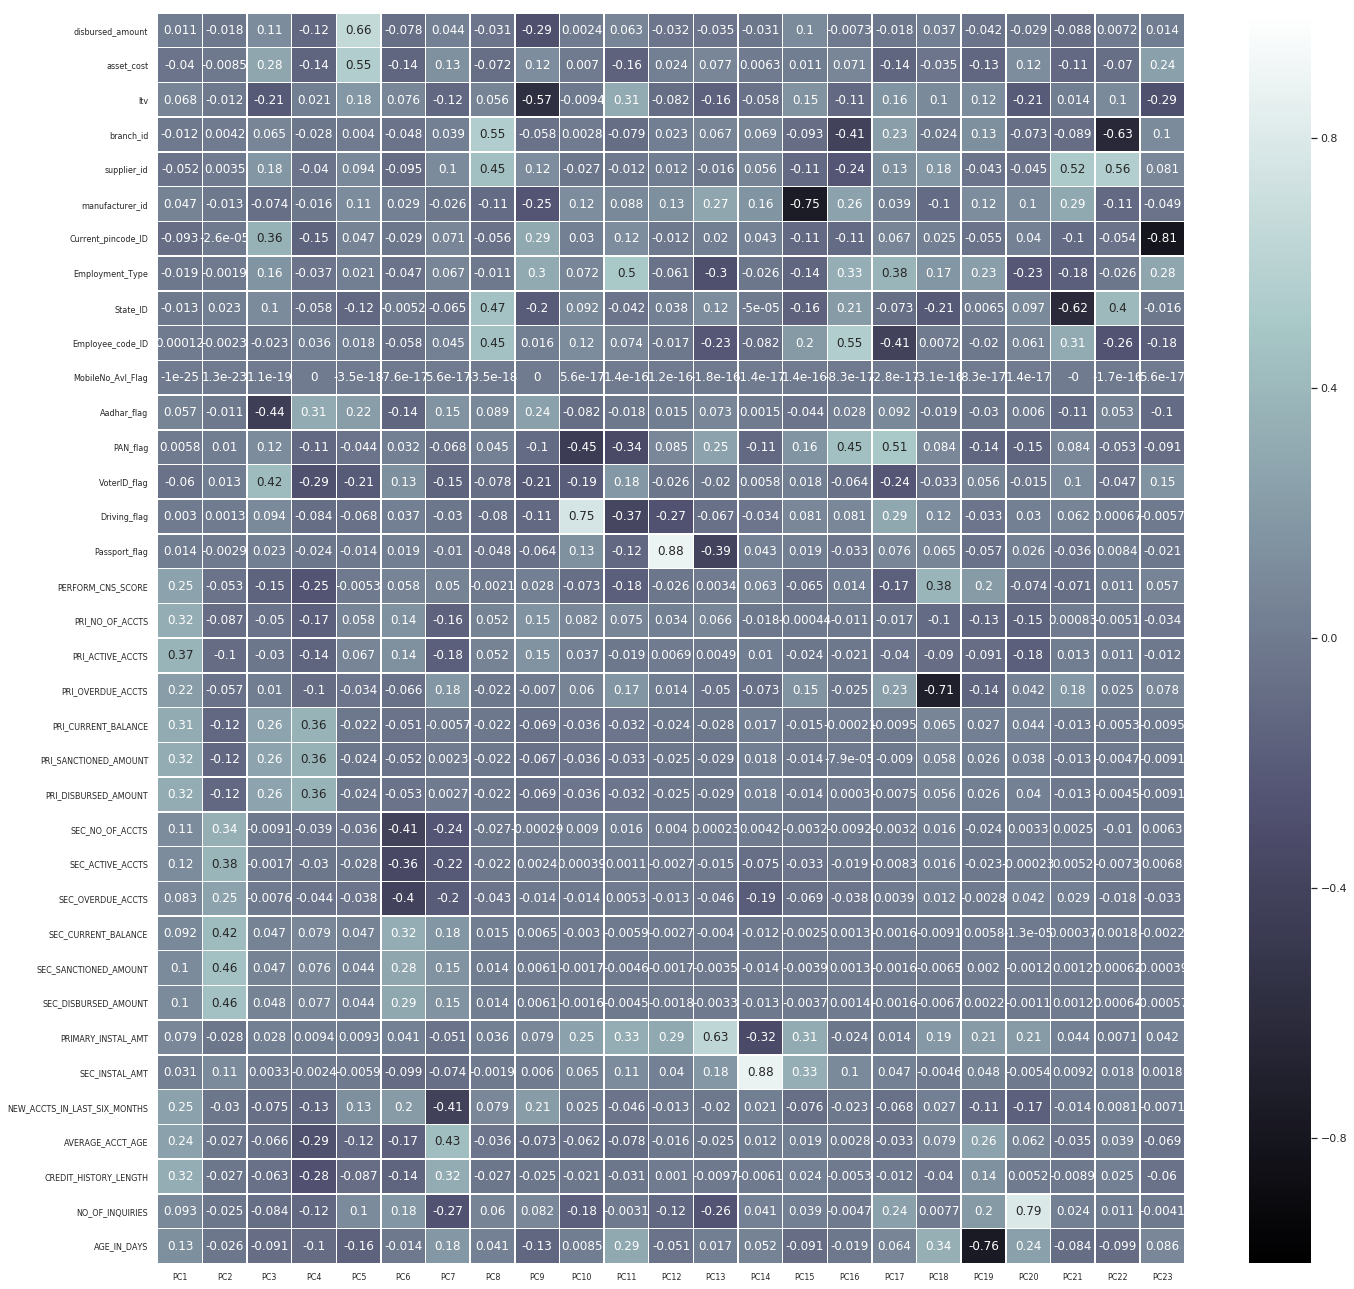

In [0]:
# Visualizing actual values

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

fig, ax = plt.subplots(figsize=(23,23))
ax = sns.heatmap(loadings.transpose(), center=0, linewidths=0.5, 
                 cmap="bone", vmin=-1, vmax=1, annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)

**Result of PCA.**

We have reduced our 36 features to 23 components, and we still have 93% of our information. We have also visualized how the original features affects our primary component.

# Cluster Analysis. Elbow method. How many clusters do we need?

The cluster analysis is done based on data, that has been scaled, but not reduced in dimensions by using PCA.

When we cluster by KMeans we will need to define the number of clusters that we would like to use. We can pick that number arbitrarely (probably not a good idea) or we can run the code below.


In [0]:
# This code takes a long time to run (345.000 rows)
# Therefore the output has been saved after the first runthrough and is displayed as an image.
# If you want to run this code, then change run = yes in the line below.
# %time

run = "no"

if run == "yes":
  # Installing KMeans
  from sklearn.cluster import KMeans
  # Number of cluster that we want to visualize.
  testnumber = 20
  inertia = []
  for i in range(1,testnumber):
    k_means = KMeans(n_clusters=i)
    inertia.append(k_means.fit(loans_scaled).inertia_)
  sns.lineplot(y = inertia, x = range(1,testnumber))

else:
  print("No plot shown here. Se image from previously below. If you want to run code, change run = \"no\" to yes.")
  print("Warning: It takes a long time with 345.000 rows.")
  
# A plot will be made. 

No plot shown here. Se image from previously below. If you want to run code, change run = "no" to yes.


Saved output from first run of loop.

![Show broken elbow](http://netfordig.dk/m1project/elbowforclusters.png)

# Conclusion in number of clusters.

There is no real break in the elbow. More like a straight line. We will assume that 6 clusters is an optimal number.

# Visualizing of the first 2 Principal Components.

<IPython.core.display.Javascript object>

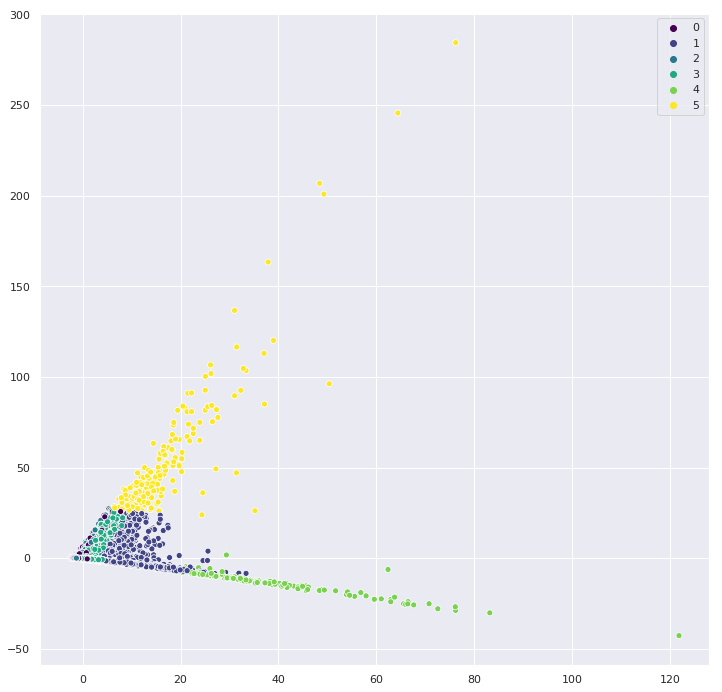

In [0]:
# Javascript in order to avoid have two scrollbars.
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

clusterer = KMeans(n_clusters=6) 
clusterer.fit(loans_principal_components) 

# Now we can plot in our points with some coloring.
plt.figure(figsize=(12,12))
g = sns.scatterplot(loans_principal_components[:,0], loans_principal_components[:,1], hue=clusterer.labels_, legend='full', palette='viridis')

legend = g.get_legend()

The plot above has been colored based on the labels in the KMeans cluster fit.

Below is another visualization, based on the default-facor (1 or 0). 

<IPython.core.display.Javascript object>

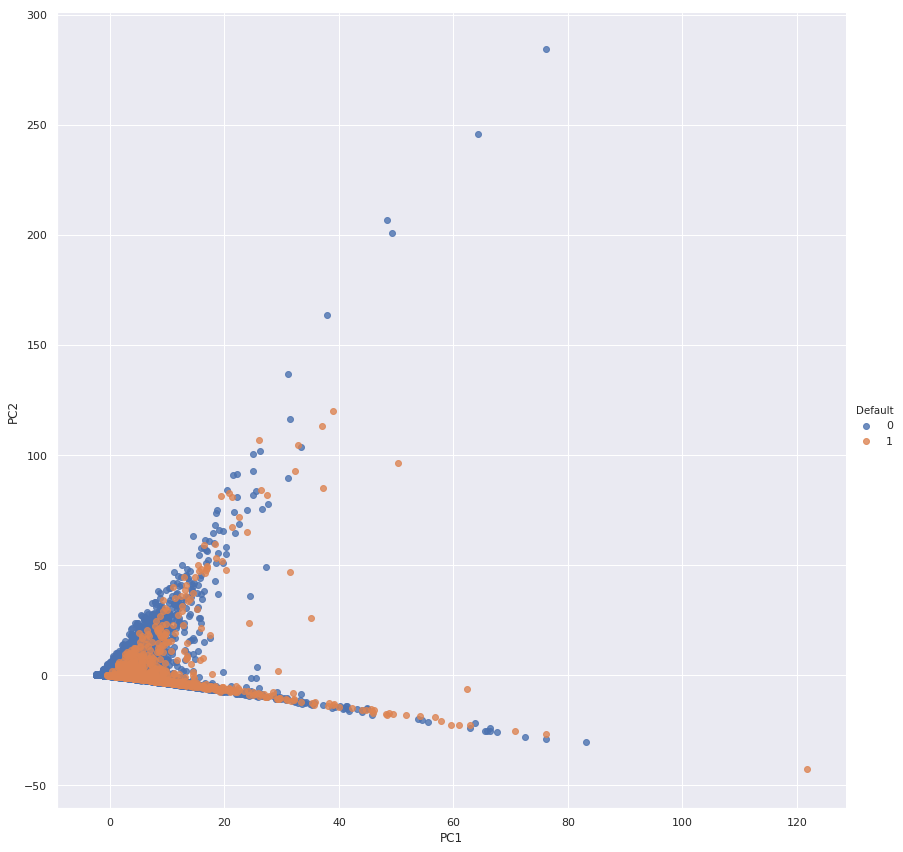

In [0]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

from sklearn.decomposition import PCA
model = PCA(n_components=23) 

# Fit model with our scaled data.
model.fit(loans_scaled) 

# Making a two dimensional visualisation.
X_2D = model.transform(loans_scaled) 

loans['PC1'] = X_2D[:, 0]
loans['PC2'] = X_2D[:, 1]

# Plot by delinquent account.
sns.lmplot("PC1", "PC2",hue='Default', data=loans, fit_reg=False, height=12, aspect=1.0);

# **Inspection of the distribution of geographical states across the clusters.**

This (and other combinations) is possible with the Bokeh Crosshair, but it takes a lot af RAM and freezes the page often. It is not recommended to run it. If you want to run it anyway, change run = "yes" below.

In [0]:
run = "no"

if run == "yes":
  # Load the needed bokeh modules.
  from bokeh.models import ColumnDataSource
  from bokeh.plotting import figure, show, output_notebook
  from bokeh.palettes import Spectral6
  from bokeh.transform import factor_cmap

  clusterer = KMeans(n_clusters=6) # number of clusters based on where the elbow breaks.
  clusterer.fit(loans_principal_components) # We now plt the clusters based on the data that has been PCAéd.


  # Define the data that we are going to use as a dictionary.

  d = {'y':loans_principal_components[:,1],'x':loans_principal_components[:,0], 'State': loans.State_ID, 
       'cluster': pd.Series(clusterer.labels_).map({0:'a',1:'b',2:'c',3:'d',4:'e',5:'f'}),
       }

  # Define and transform a color-palette.

  colors = factor_cmap('cluster', palette=Spectral6, factors=d['cluster'].unique())

  # Transform the data to Bokeh format.
  d = ColumnDataSource(d)

  # Define interactive tooling and plot for notebook output.

  output_notebook()

  TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select"
  p = figure(tools=TOOLS)
  p.hover.tooltips = [('State', "@State")]
  p.scatter(x='x', y='y',fill_alpha=0.8,
            color = colors,
            line_color = None,
            radius = 0.1,
            source=d)
  show(p)
else:
  print("We are not running crosshairs. Freezes the system with 345K rows.")
  

We are not running crosshairs. Freezes the system with 345K rows.


Another way to inspect the clusters is to use crosstabs. In this case with 345K rows it is probably the most effective way. Se below.

In [0]:
# Looking at clusters across geopgraphical states.
model = KMeans(n_clusters=6)
model.fit(loans_scaled)
loans['cluster'] = model.labels_
pd.crosstab(loans['State_ID'], loans['cluster'], normalize='columns')

cluster,0,1,2,3,4,5
State_ID,,,,,,
1,0.007687,0.051948,0.064467,0.032599,0.065821,0.142132
2,0.008791,0.019481,0.024608,0.023385,0.021095,0.000000
3,0.222014,0.058442,0.085111,0.171619,0.060512,0.015228
4,0.034746,0.233766,0.256370,0.212111,0.231196,0.081218
5,0.027964,0.038961,0.035513,0.048611,0.030115,0.005076
6,0.127827,0.207792,0.162381,0.127992,0.145689,0.035533
7,0.007687,0.000000,0.029561,0.041252,0.017947,0.015228
8,0.012966,0.116883,0.070761,0.049822,0.135213,0.081218
9,0.071722,0.084416,0.065984,0.050144,0.110171,0.106599


# SML CLASSIFYING DELIQUENT LOANS.

Overall the assigment is to make predictions between states (default or not) => classification. Is something one thing or another thing? Is this case: Based on a range of independent variables, will a customer default or not?



#Split data into training and test datasets. 75%/25%

We train models using data. After training and fitting the model, we would like to test it, and see how well it performs. 

But if we test the model on the same data, that we trained it on, we would get a perfect testscore. But that would be useless. We need to know, how well the model does when predicting or classifying on NEW data.

So how do we test the model? The answer is, to test it on data, that it has not seen before. That means splitting our data in 2 parts, a training set and a testing set. 

We could do it by hand and just take the first part of a set for training and the second half for testing. But if our data eg. is a timeserie over a year, we would probably not get data that really represents what we are looking for. 

Imagine that our trainingdata is the first 9 months of the year, and the test data is the last 3 months of the year. If we are looking to predict how many lawnmovers are sold based on a independent variable, we would proably get a somewhat precise result. If we then test the model on our test data, we would proably get a low testscore, as the data is not representative for what we are looking for (eg. not many people buy lawnmovers in december, regardless of the independent variable) The same thing could be said viceversa about christmas shopping. This is offcourse a very exaggerated example. but it goes to show, that we should rather not divide the data into train and test manually.

A better way would be to use the train_test_split utility function below.

In [0]:
# Defining the dependent variable. What are we looking for? Will the customer default?
y = loans.Default  

# Importing the train-test split function.
from sklearn.model_selection import train_test_split

# Making the split. We keep 75% for training and 25% for test.
X_train, X_test, y_train, y_test = train_test_split(loans_scaled, y, test_size = 0.25, random_state=42)


In [0]:
# Take a look at the train and test set
print( X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(236361, 36) (236361,)
(78787, 36) (78787,)


In [0]:
# Some things we are going to need for later.

# Disabling FutureWarnings beacuse they are annoying to look at.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Classification Report for later evaluatoion of performance
from sklearn.metrics import classification_report

# Import CrossValidation
from sklearn.model_selection import cross_val_score

# LOGISTIC REGRESSION

In [0]:
# Choosing model class. This is where we decide, which model to use. In this case logistic regression.
# Installing log.res-model.
from sklearn.linear_model import LogisticRegression


# instantiating the model.
model = LogisticRegression()


# Getting our crossvalidation testscore. 
# Please note that this is done on training data.
# Scores gives us a list of scores on each of the 5 subset, that is used in the traning 
scores = cross_val_score(model, X_train, y_train, cv = 5) # WHY 5? See my text and explanation below the code.


# Fitting the model on the training data.
model.fit(X_train, y_train)

# Printing out the result of the training.
print("Scores for crossvalidation on each trainingdatafold. cv=5")
print(scores)
print("-------\n")
print("Mean score and std on the trainingset")
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
print("-------\n")

# Prediction on the models succes, based on the testdata.
y_model = model.predict(X_test)

# Model score
print("Testscores for fittet model")
print(model.score(X_test, y_test))
print("-------\n")

# Classification report => Se explation below the code.
print("Classification report")
print(classification_report(y_test,y_model))

Scores for crossvalidation on each trainingdatafold. cv=5
[0.98677892 0.98680008 0.98665172 0.98694788 0.98654566]
-------

Mean score and std on the trainingset
Accuracy: 0.98674 (+/- 0.00027)
-------

Testscores for fittet model
0.9859113813192532
-------

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     77716
           1       0.43      0.11      0.18      1071

    accuracy                           0.99     78787
   macro avg       0.71      0.55      0.59     78787
weighted avg       0.98      0.99      0.98     78787



**A few words about cross validation.**

By splitting data into train and test sets, we reduce the number of rows that we can train on. 

We had 315.148 loans (after removing outliers), but now we only train on 236.361. It makes sense to keep 78.787 for later to do the test, but our training will suffer because of it.
Also our model is only as good as the way the data Is split. Even though we didn´t do a manual split, our data might not be representative for our models ability to generalize.

We can compensate for the loss of training data by using crossvalidation. The same way as we split our data into training and test, we now split the training data into parts called folds (k folds), eg. 5 folds.
We then train on 4 folds and test on 1 fold. We repeat the process 5 times until all combinations have been done. We will get at score for each test and can calculate a mean based on these scores.

As to the number of folds that should be used, the general rules seems to be about 4 or 5 on most datasets. Very large sets can be done in 10 folds, but more folds require more computational power. We have not be able to find a way to calculate the optimal number of folds. 

**Classification report. What does the numbers mean?**

Precision tells us how precise our model is. Eg. if False is 98%, it means that everytime the model classified a loan as being 'Default' the model was right 98% of the time. 

Recall tells us the models ability to find all actual positives (or negatives). Eg. if False is 96%, it means all instances of loans classified as being default, we only found 96% of them

The F1 best score is 1.0 and the worst is 0.0. As a rule of thumb, the weighted average of F1 should be used to compare classifier models. That means that we can use this value to compare our model, in this case a logistic regression, to the other two models, that we are going to use.

Support tells us something about the testset being used. We can see, that of the 78787 loans, 77716 of them are not default and 1071 of the are default.

**Confusion Matrix.**
Let´s see a confusion matrix.

Upper left shows us the True Negatives. eg. How many loans were classified as not default and how many were in fact not default.

Lower right shows us the True Positive. eg. How many loans were classified as default and how many were in fact default.

It´s in the upper left and the lower right, where we want as many observations as possible. These are where we do things right.

Upper right and Lower left shows us, where thing are not right. We would want a model, that minimizes the observations in the boxes.

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_model)
print(cm)

# This gives us a CM.

[[77557   159]
 [  951   120]]


In [0]:
# For that we need to install an updated version of the MLxtend library (it will make plotting of the confusion matrix easy)
!pip install -U mlxtend
# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix

# We will also import sklearns confusion matrix module that will make it easy to produce a confusion matrix
# It's actually just a cross-tab of predicted vs. real values
from sklearn.metrics import confusion_matrix


Requirement already up-to-date: mlxtend in /usr/local/lib/python3.6/dist-packages (0.17.0)


(<Figure size 842.4x595.44 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb32ba44d30>)

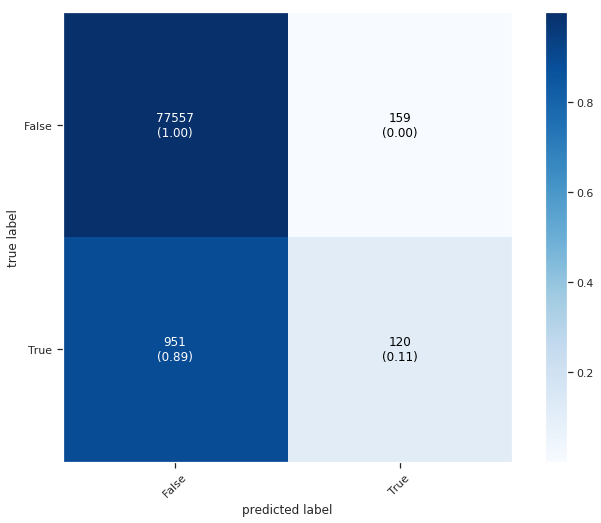

In [0]:
# Plotting CM
#plt.ylabel('somestring')
#plt.ylabel('true label')
#plt.ylabel = 'somestriddng'
#plt.xlabel = 'somestr333ing'

classNames = ['False','True']
plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names = classNames)

# DECISION TREE

In [0]:
# Choosing model class. This is where we decide, which model to use. In this case DecisionTreeClassifier.
# Installing Decision tree-model.
from sklearn.tree import DecisionTreeClassifier


# instantiating the model.
model = DecisionTreeClassifier()


# Getting our crossvalidation testscore. 
# Please note that this is done on training data.
# Scores gives us a list of scores on each of the 5 subset, that is used in the traning 
scores = cross_val_score(model, X_train, y_train, cv = 5) 


# Fitting the model on the training data.
model.fit(X_train, y_train)

# Printing out the result of the training.
print("Scores for crossvalidation on each trainingdata. cv=5")
print(scores)
print("-------\n")
print("Mean score and std on the trainingset")
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
print("-------\n")

# Prediction on the models succes, based on the testdata.
y_model = model.predict(X_test)

# Model score
print("Testscores for fittet model")
print(model.score(X_test, y_test))
print("-------\n")

# Classification report => Se explation below the code.
print("Classification report")
print(classification_report(y_test,y_model))

Scores for crossvalidation on each trainingdata. cv=5
[0.97992512 0.9792905  0.97852852 0.97897275 0.97998773]
-------

Mean score and std on the trainingset
Accuracy: 0.97934 (+/- 0.00112)
-------

Testscores for fittet model
0.978422836254712
-------

Classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     77716
           1       0.24      0.27      0.25      1071

    accuracy                           0.98     78787
   macro avg       0.61      0.63      0.62     78787
weighted avg       0.98      0.98      0.98     78787



In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_model)
print(cm)

[[76801   915]
 [  785   286]]


(<Figure size 842.4x595.44 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb31ecfa940>)

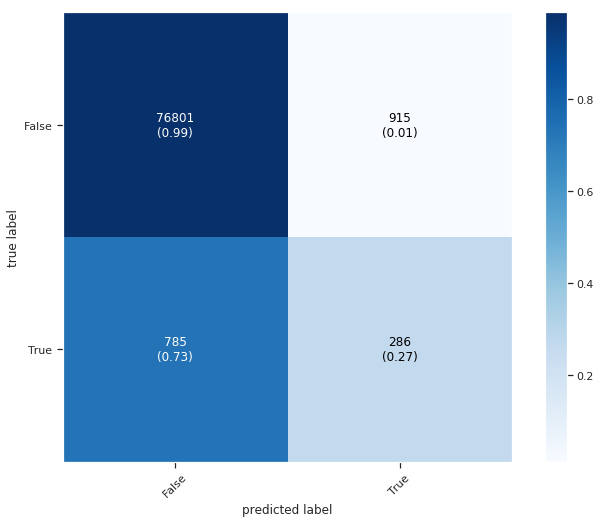

In [0]:
# Plotting CM
classNames = ['False','True']
plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names = classNames)

# XG BOOST

In [0]:
# Choosing model class. This is where we decide, which model to use. In this case XG Boost.
# Installing XG BOOST.
import xgboost as xgb

# instantiating the model.
model = xgb.XGBClassifier()

# Getting our crossvalidation testscore. 
# Please note that this is done on training data.
# Scores gives us a list of scores on each of the 5 subset, that is used in the traning 
scores = cross_val_score(model, X_train, y_train, cv = 5) 


# Fitting the model on the training data.
model.fit(X_train, y_train)

# Printing out the result of the training.
print("Scores for crossvalidation on each trainingdata. cv=5")
print(scores)
print("-------\n")
print("Mean score and std on the trainingset")
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
print("-------\n")

# Prediction on the models succes, based on the testdata.
y_model = model.predict(X_test)

# Model score
print("Testscores for fittet model")
print(model.score(X_test, y_test))
print("-------\n")

# Classification report => Se explation below the code.
print("Classification report")
print(classification_report(y_test,y_model))

Scores for crossvalidation on each trainingdata. cv=5
[0.98787892 0.98777315 0.98794212 0.98830174 0.98722261]
-------

Mean score and std on the trainingset
Accuracy: 0.98782 (+/- 0.00070)
-------

Testscores for fittet model
0.9873202431873278
-------

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     77716
           1       0.65      0.15      0.24      1071

    accuracy                           0.99     78787
   macro avg       0.82      0.57      0.62     78787
weighted avg       0.98      0.99      0.98     78787



In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_model)
print(cm)

[[77629    87]
 [  912   159]]


(<Figure size 842.4x595.44 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb31ec6f0b8>)

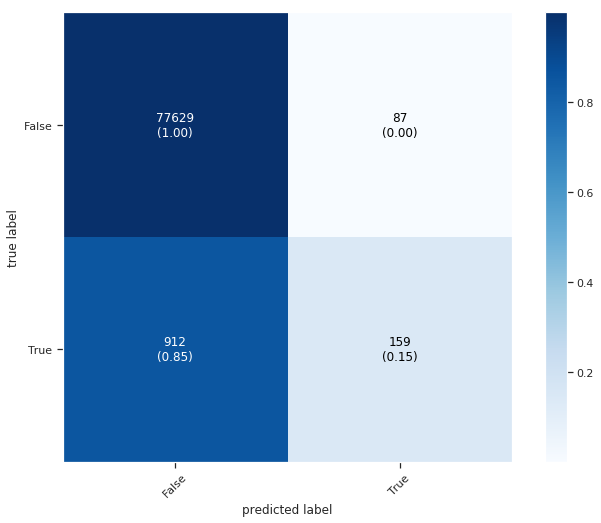

In [0]:
# Plotting CM
classNames = ['False','True']
plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names = classNames)

# CONCLUSION

The overall target of this assignment was to create a model which purpose was to predict whether a disbursement of a car loan would end up as a default or not. Before this could be done we had to do some preprocessing on our data. In the overall preprocessing the two dataset ‘train’ and ‘test’ was merged and alligned to a new dataset called ‘loans’. Next we explored the ‘loans’ dataset through visualisation and corrected it for outliers. 

In order to do some unsupervised and supervised machine learning we then scaled the ‘loans’ dataset. In the unsupervised machine learning our data was compressed from 36 to 23 components through a PCA with an explained variance of 94% and clusters were visualized.

Finally we performed some supervised ML by creating three different models to predict default or not default loans. Overall the three models performed reasonable similar with a slightly advantage to the XGBoost model. This model was capable of predicting the target outcome with a 98.7% accuracy in the test set.

